https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/  
https://medium.com/analytics-vidhya/time-series-analysis-using-arima-and-lstm-in-python-and-keras-part2-74a79636568

# first need data  

In [1]:
import os
os.listdir('../Data/Weekly/')

['AUDUSD10080_20200510.csv']

In [2]:
import pandas as pd

In [3]:
dat = pd.read_csv('../Data/Weekly/AUDUSD10080_20200510.csv', header=None)
dat.columns = ['Date','Time','Open','Close','High','Low','Volume']
dat

,Date,Time,Open,Close,High,Low,Volume
0,2000.03.19,00:00,0.60670,0.61160,0.60150,0.60800,400
1,2000.03.26,00:00,0.61050,0.61700,0.60190,0.60800,615
2,2000.04.02,00:00,0.60650,0.61050,0.59580,0.59900,561
3,2000.04.09,00:00,0.59690,0.60080,0.59350,0.59800,456
4,2000.04.16,00:00,0.60260,0.60460,0.58850,0.59480,536
...,...,...,...,...,...,...,...
1047,2020.04.12,00:00,0.63401,0.64448,0.62639,0.63622,1292124
1048,2020.04.19,00:00,0.63578,0.64059,0.62535,0.63961,1129763
1049,2020.04.26,00:00,0.63802,0.65698,0.63802,0.64201,1038188
1050,2020.05.03,00:00,0.64112,0.65478,0.63727,0.65295,960806


## get a look at time series

<AxesSubplot:xlabel='Date'>

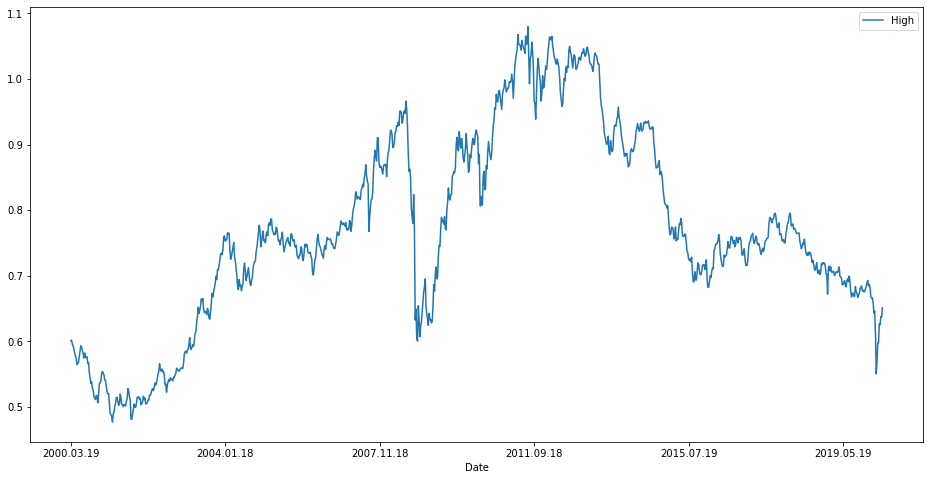

In [14]:
dat.plot(x = 'Date', y = 'High',kind = 'line', figsize = (16,8))

In [17]:
dat.isnull().sum()

Date      0
Time      0
Open      0
Close     0
High      0
Low       0
Volume    0
dtype: int64

# then need to massage data  
    do we need to pad  
    setup test train data  
    create sequences

## scale then sequence the data

In [105]:
High = dat['High'].values

High = numpy.reshape(High, (-1,1))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
High_Scaled = scaler.fit_transform(High)

In [127]:
X, Y = [], []
for i in range(60, len(High_Scaled)):
    X.append(High_Scaled[i-60:i, 0])
    Y.append(High_Scaled[i,0])
    
X, Y = numpy.array(X), numpy.array(Y)


## Train test

In [108]:
test_pct = 0.333
train_cut = int(len(X)*(1-test_pct))

In [158]:
X_train, Y_train = X[:train_cut,:], Y[:train_cut]
X_test, Y_test = X[train_cut:], Y[train_cut:]

In [159]:
#need to reshape for LSTM as it wants a TENSOR ...(LEN, WID, Num_feat)
X_train = numpy.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = numpy.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# then need to setup lstm model  

In [289]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error

In [344]:
def setupMod(modSettings):
    model = Sequential()

    for i,row in modSettings.iterrows():
        max_iter = modSettings.shape[0] - 1
        a = int(row[0])
        b = row[1]
        if i == 0: 
            model.add(LSTM(units = a, return_sequences = True, input_shape = (X_train.shape[1],1)))
        elif i == max_iter:
            model.add(LSTM(units = a))
        else: 
            model.add(LSTM(units = a, return_sequences = True))
        model.add(Dropout(b))  

    model.add(Dense(units = 1))

    model.summary()
    return(model)  


In [358]:
modSettings = pd.DataFrame([[24, 0.12],[24, 0.12],[24,0.12],[24,0.12],[24, 0.12],[24,0.12]])
model = setupMod(modSettings)    

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 60, 24)            2496      
_________________________________________________________________
dropout_52 (Dropout)         (None, 60, 24)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 60, 24)            4704      
_________________________________________________________________
dropout_53 (Dropout)         (None, 60, 24)            0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 60, 24)            4704      
_________________________________________________________________
dropout_54 (Dropout)         (None, 60, 24)            0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 60, 24)          

## Model creation and FIT

In [359]:
import keras
# learning rate #########play with this
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10 **(epoch/20))
opt = keras.optimizers.Adam(lr = 1e-1)

In [360]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae','mape'])

In [361]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'loss', mode = 'min', patience = 20)
mc = keras.callbacks.ModelCheckpoint('best_model_24.h5', monitor = 'loss', mode = 'min', verbose = 0, save_best_only = True) #save best during training

In [362]:
#hist = model.fit(X_train, Y_train, epochs = 333, batch_size = 33, verbose = 0, callbacks = [mc, lr_schedule, early_stopping],
#                validation_data = (X_test, Y_test))
hist = model.fit(X_train, Y_train, epochs = 333, batch_size = 33, verbose = 0,
                 callbacks = [mc, early_stopping],
                 validation_data = (X_test, Y_test))
#try different epoch sizes
#try different batch sizes
#try different number of features
#try different learning rates......opt = keras.optimizers.Adam(lr = 0.5e-2)

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])


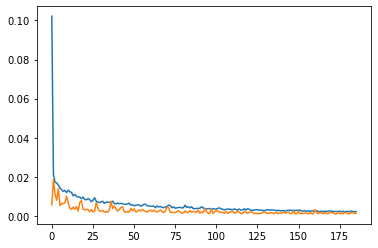

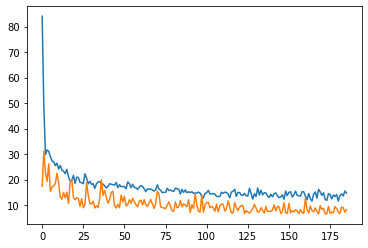

In [365]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()
#plt.semilogx(hist.history['lr'], hist.history['loss'])
#plt.show()
plt.plot(hist.history['mape'])
plt.plot(hist.history['val_mape'])
plt.show()

# Load best mod to review predictions  

In [366]:
from keras.models import load_model
#best = load_model('best_model.h5')
best = load_model('best_model_24.h5')

In [367]:
preds = best.predict(X_test)

In [368]:
mean_squared_error(preds,Y_test)

0.0012514213337943773

In [369]:
from sklearn.metrics import explained_variance_score, max_error 
from sklearn.metrics import mean_absolute_error, median_absolute_error
from sklearn.metrics import mean_tweedie_deviance

In [370]:
Test_Scores = {"Mean Square Error": round(mean_squared_error(Y_test, preds),5),
               "Explained Variance Score": round(explained_variance_score(Y_test, preds),5),
               "Max Error": round(max_error(Y_test, preds),5),
               "Mean Absolute Error": round(mean_absolute_error(Y_test, preds), 5),
               "Median Absolute Error": round(median_absolute_error(Y_test, preds), 5),
               "Mean Tweedie Deviance (P=1)": round(mean_tweedie_deviance(Y_test, preds, power = 1),3),
               "Mean Tweedie Deviance (P=2)": round(mean_tweedie_deviance(Y_test, preds, power = 2), 3)}

for item in Test_Scores:
    print(f'{item:<30} {Test_Scores[item]:<8}')


Mean Square Error              0.00125 
Explained Variance Score       0.8344  
Max Error                      0.20647 
Mean Absolute Error            0.02604 
Median Absolute Error          0.02022 
Mean Tweedie Deviance (P=1)    0.003   
Mean Tweedie Deviance (P=2)    0.011   


## Plot preds against actuals

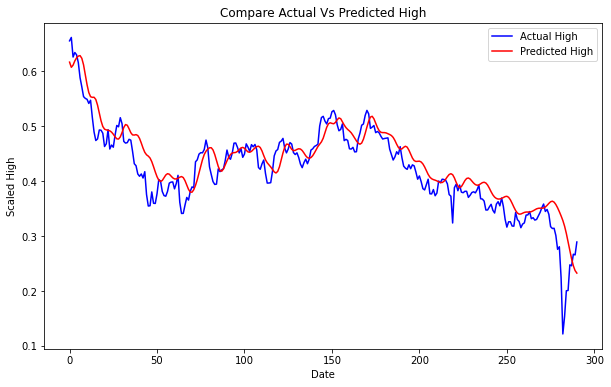

In [371]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
plt.plot(Y_test, color = 'blue', label = 'Actual High')
plt.plot(preds, color = 'red', label = 'Predicted High')
plt.title('Compare Actual Vs Predicted High')
plt.xlabel('Date')
plt.ylabel('Scaled High')
plt.legend()
plt.show()

In [372]:
print(scaler.inverse_transform(preds)[-10:])
print(High[-10:])

[[0.68003005]
 [0.6749953 ]
 [0.6687308 ]
 [0.66078615]
 [0.6515654 ]
 [0.6419369 ]
 [0.63291913]
 [0.62540984]
 [0.6200867 ]
 [0.6173498 ]]
[[0.6123 ]
 [0.55064]
 [0.56997]
 [0.59799]
 [0.59832]
 [0.62639]
 [0.62535]
 [0.63802]
 [0.63727]
 [0.65143]]


# then need to determine if can improve model  